In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# check GPU status
!nvidia-smi

Sun Feb  2 21:55:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:BD:00.0 Off |                    0 |
| N/A   35C    P0             58W /  400W |     115MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 1. load config
import json
# config_fname = 'configs/ours-train-LaMoD-patchify-video.json'
config_fname = 'configs/ours-train-LaMoD-aligned-frames.json'

config = json.load(open(config_fname))

In [5]:
check_dict(config)

data                                                         dict_keys(['DENSE_filenames', 'train_subject_exclude_patterns', 'val_subject_patterns', 'test_subject_patterns'])
datasets                                                     dict_keys(['train', 'val', 'test'])
networks                                                     dict_keys(['registration', 'latent', 'motion_regression'])
training                                                     dict_keys(['seed', 'scheme', 'batch_forward_method', 'reg_forward_data', 'regression_output_type', 'disp_masking', 'mask_padded_frames', 'resize_before_regression', 'batch_size', 'epochs', 'enable_random_rotate', 'random_rotate_prob_thres', 'epochs_without_improvement_tolerance', 'save_best_model_interval', 'training_latent_model_epoch_interval', 'training_motion_decoder_epoch_interval', 'optimization'])
losses                                                       dict_keys(['DENSE_disp_reconstruction_L1', 'DENSE_disp_reconstruction_MSE', 'D

In [6]:
from modules.data import glob_star
import json
import glob

def load_DENSE_data(DENSE_data_fnames):
    # Load raw data
    all_data_raw = []
    all_data_fnames = list(glob_star(DENSE_data_fnames))
    for all_data_fname in all_data_fnames:
        all_data_raw += np.load(all_data_fname, allow_pickle=True).tolist()
    
    # Keep only the necessary files
    all_data = []
    for datum_idx, datum_raw in enumerate(all_data_raw):
        loaded_datum = {}

        # loaded_datum = get_data_from_slice(datum_raw, data_to_feed)        
        loaded_datum['DENSE_disp'] = np.stack([datum_raw['DENSE_Lag_displacement_field_X'], datum_raw['DENSE_Lag_displacement_field_Y']], axis=0)
        loaded_datum['myo_masks'] = datum_raw['DENSE_myo_masks_rescaled']#[None]
        # loaded_datum['PositionA'] = datum_raw['AnalysisInfo']['PositionA']
        # loaded_datum['PositionB'] = datum_raw['AnalysisInfo']['PositionB']
        loaded_datum['slice_mat_filename'] = str(datum_raw.get('DENSE_slice_mat_filename', 'None'))
        loaded_datum['slice_location'] = float(datum_raw.get('DENSE_slice_location', -1e-3))
        
        loaded_datum['subject_id'] = datum_raw['patient_id']
        loaded_datum['slice_idx'] = datum_idx
        loaded_datum['slice_full_id'] = f'{datum_raw["patient_id"]}-{datum_idx}'
        loaded_datum['SequenceInfo'] = datum_raw['SequenceInfo']
        loaded_datum['ori_n_frames'] = loaded_datum['myo_masks'].shape[-1]

        all_data.append(loaded_datum)
    return all_data

all_data = load_DENSE_data(config['data']['DENSE_filenames'])

In [7]:
# 2. load all data splits
train_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') not in config['data']['train_subject_exclude_patterns']]
}
val_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['val_subject_patterns']]
}
test_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['test_subject_patterns']]
}

data_splits = {
    'train': train_split,
    'val': val_split,
    'test': test_split
}

In [8]:
check_dict(train_split['data'][0])

DENSE_disp                                                   (2, 48, 48, 22)     
myo_masks                                                    (128, 128, 22)      
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
SequenceInfo                                                 (2, 3)              
ori_n_frames                                                 22                  


In [9]:
# 4. Building dataset
from modules.data.dataset import build_datasets
datasets = build_datasets(data_splits, config['datasets'])
# print the length of each dataset
for dataset_name, dataset in datasets.items():
    print(f'{dataset_name} dataset length: {len(dataset)}')

Aligning displacement field frames to 41 frames
# of frames before alignment: [18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 75]
# of frames after alignment: [41]
Aligning displacement field frames to 41 frames
# of frames before alignment: [18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 75]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment: [65, 39, 41, 43, 45, 47, 49, 29, 51, 53, 24, 57, 59, 61, 25, 31]
# of frames after alignment: [41]
Aligning displacement field frames to 41 frames
# of frames before alignment: [65, 39, 41, 43, 45, 47, 49, 29, 51, 53, 24, 57, 59, 61, 25, 31]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment

In [10]:
check_dict(datasets['train'][0])

DENSE_disp                                                   (2, 40, 48, 48)     
src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
ori_n_frames                                                 22                  


In [11]:
check_dict(datasets['train'][-1])

DENSE_disp                                                   (2, 40, 48, 48)     
src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/dod_ya_ROI.3.mat
slice_location                                               -0.4107601991522    
subject_id                                                   dod_ya              
slice_idx                                                    740                 
slice_full_id                                                dod_ya-740          
ori_n_frames                                                 55                  


In [12]:
# 6. Building model
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to( device)
# model = build_model(config['network'])

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [13]:
# Training
from modules.trainer import build_trainer
# config['training']['epochs'] = 15 # set only 30 epochs for debugging
# config['training']['batch_size'] = 32 # can use larger batch size if use patchified video
# config['training']['learning_rate'] = 1e-4
trainer = build_trainer(config['training'], device, config)

In [14]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

Loss DENSE_disp_reconstruction_MSE is disabled
Loss DENSE_disp_reconstruction_EPE is disabled
latent lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f74a68267a0>
motion_regression lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f74a68267d0>


135it [02:55,  1.30s/it]00:00<?, ?it/s]
26it [00:16,  1.58it/s]047e-02:   0%|          | 0/500 [02:55<?, ?it/s]
Epoch 0 | Train Loss 4.047e-02:   0%|          | 1/500 [03:12<26:38:38, 192.22s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.040822723788594716,
    "train/denoising": 0.01707262146735081,
    "train/total_loss": 0.10713082825965674,
    "train/noise_prediction_error": 0.01707262146735081,
    "train/DENSE_disp_reconstruction_error": 0.032162861618455156,
    "val/DENSE_disp_reconstruction_L1": 0.05469227951622521,
    "val/denoising": 0.0092009929402803,
    "val/total_loss": 0.130128708475635,
    "val/noise_prediction_error": 0.0092009929402803,
    "val/DENSE_disp_reconstruction_error": 0.05703444343336216
}


135it [02:54,  1.29s/it]
26it [00:16,  1.59it/s]523e-02:   0%|          | 1/500 [06:06<26:38:38, 192.22s/it]
Epoch 1 | Train Loss 5.523e-02:   0%|          | 2/500 [06:22<26:26:50, 191.19s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.03453214775696383,
    "train/denoising": 0.007811332162883547,
    "train/total_loss": 0.07222652042830967,
    "train/noise_prediction_error": 0.007811332162883547,
    "train/DENSE_disp_reconstruction_error": 0.022071708302366915,
    "val/DENSE_disp_reconstruction_L1": 0.053839770957594776,
    "val/denoising": 0.007003817438649444,
    "val/total_loss": 0.12308045333987462,
    "val/noise_prediction_error": 0.007003817438649444,
    "val/DENSE_disp_reconstruction_error": 0.055233048183524695
}


135it [02:53,  1.28s/it]
26it [00:16,  1.60it/s]138e-01:   0%|          | 2/500 [09:16<26:26:50, 191.19s/it]
Epoch 2 | Train Loss 1.138e-01:   1%|          | 3/500 [09:32<26:18:11, 190.53s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.03317132330952528,
    "train/denoising": 0.00699266645953887,
    "train/total_loss": 0.06751783212547884,
    "train/noise_prediction_error": 0.00699266645953887,
    "train/DENSE_disp_reconstruction_error": 0.020361175880904442,
    "val/DENSE_disp_reconstruction_L1": 0.05486147154338841,
    "val/denoising": 0.006461797908951457,
    "val/total_loss": 0.12417843082061365,
    "val/noise_prediction_error": 0.006461797908951457,
    "val/DENSE_disp_reconstruction_error": 0.05639336390752781
}
Epochs without improvement: 1 / 30


92it [01:59,  1.30s/it]
Epoch 2 | Train Loss 1.138e-01:   1%|          | 3/500 [11:31<31:50:32, 230.65s/it]

KeyboardInterrupt at epoch 3


In [15]:
# generate training set prediction
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/DENSE_disp_reconstruction_L1': 0.040395474871294496, 'train/denoising': 0.008247854286589874, 'train/total_loss': 0.0839911727722196, 'train/noise_prediction_error': 0.008247854286589874, 'train/DENSE_disp_reconstruction_error': 0.02709998937475529}


In [16]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/DENSE_disp_reconstruction_L1': 0.07651361880835181, 'test/denoising': 0.008714424073696136, 'test/total_loss': 0.16884150637324932, 'test/noise_prediction_error': 0.008714424073696136, 'test/DENSE_disp_reconstruction_error': 0.07489903917949506}


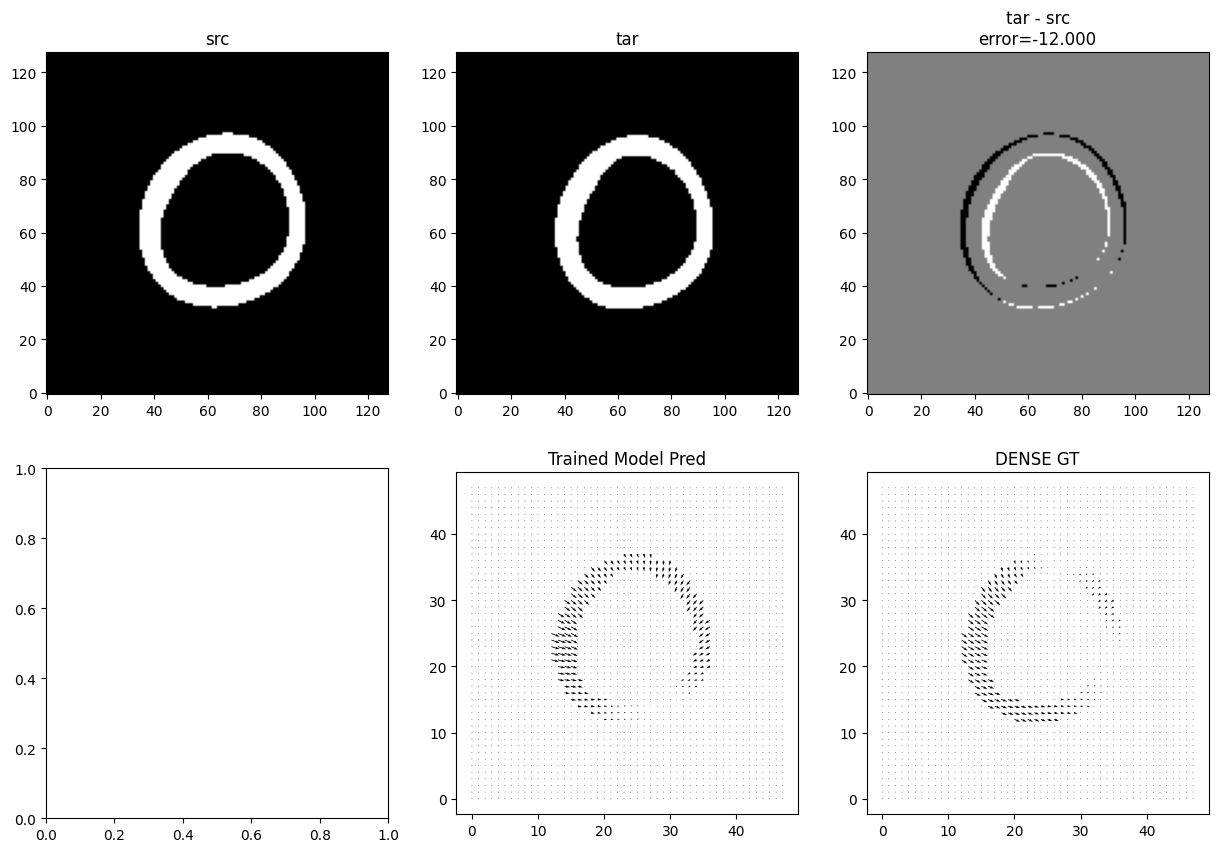

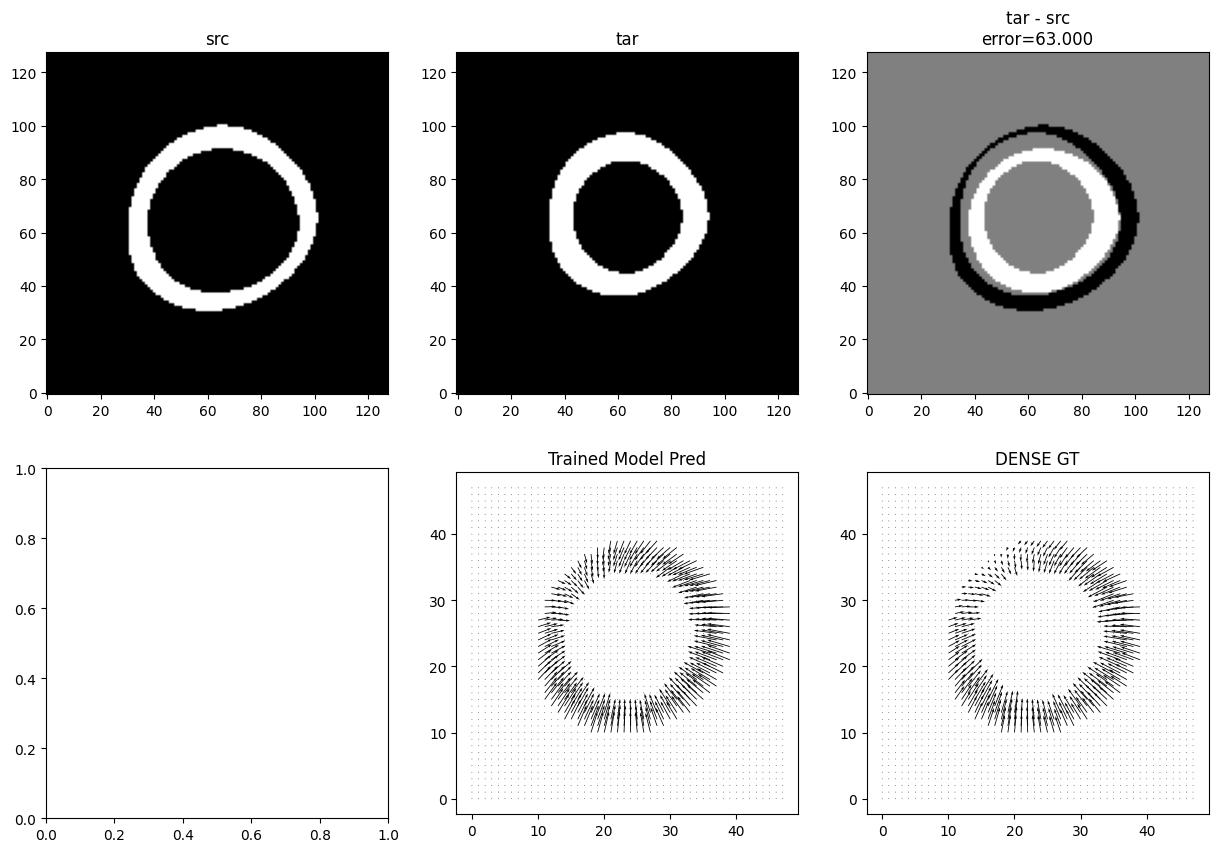

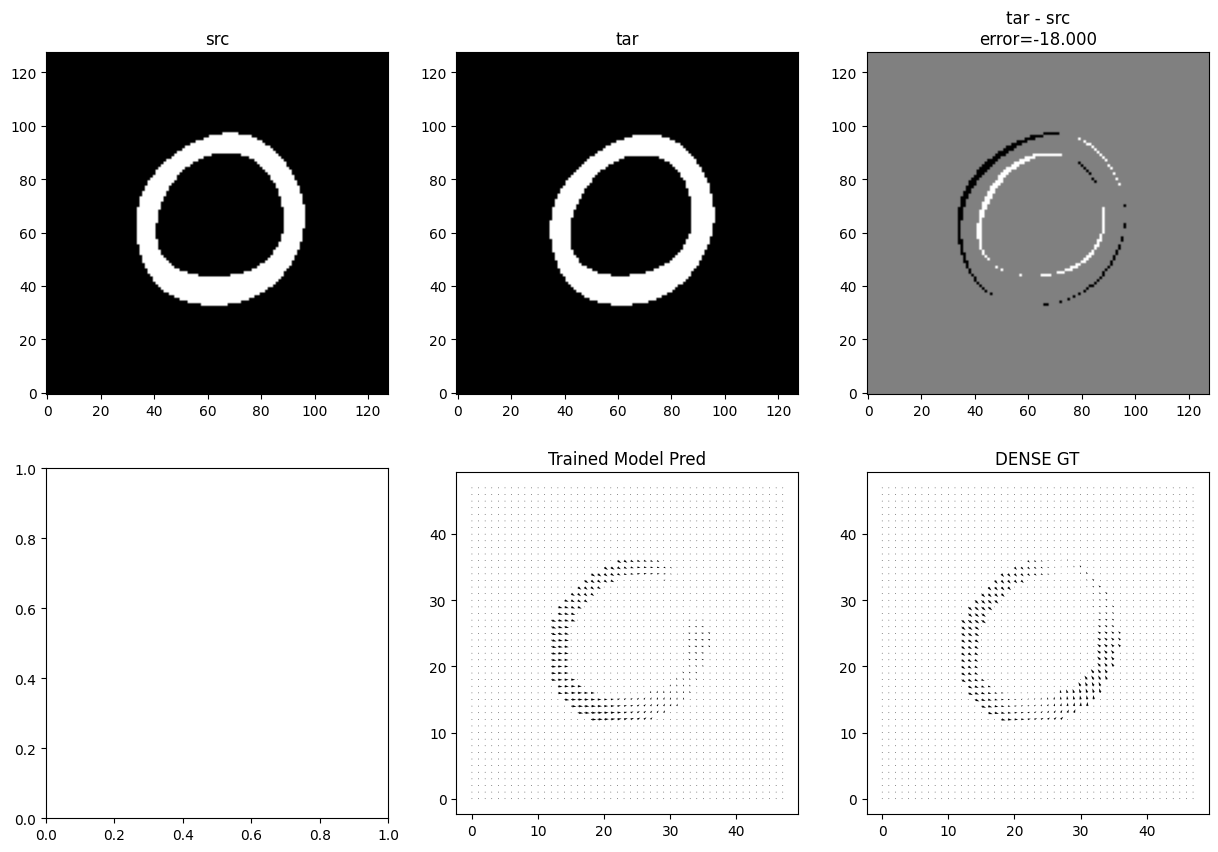

In [20]:
# compare the source, target, target-source difference, registration results, trained model prediction results
import numpy as np
import matplotlib.pyplot as plt
for check_pair_idx in [5,10,20]:
    n_frames = train_pred[check_pair_idx]['src'].shape[1]
    vis_frame = n_frames//2
    src = train_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = train_pred[check_pair_idx]['tar'][0].astype(float)[vis_frame]
    tar_src_diff = tar - src
    
    # deformed = train_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    # deformed_bin = deformed > 0.5
    # deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    # disp_reg_pred  = train_pred[check_pair_idx]['reg_disp_pred'][:, vis_frame][:, ::2,::2]
    disp_pred = train_pred[check_pair_idx]['DENSE_disp_pred'][:, vis_frame]
    disp_GT = train_pred[check_pair_idx]['DENSE_disp'][:, vis_frame]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0,0].imshow(src, cmap='gray')
    axs[0,0].set_title('src')
    axs[0,0].invert_yaxis()
    axs[0,1].imshow(tar, cmap='gray')
    axs[0,1].set_title('tar')
    axs[0,1].invert_yaxis()
    axs[0,2].imshow(tar_src_diff, cmap='gray')
    axs[0,2].set_title(f'tar - src\nerror={tar_src_diff.sum():.3f}')
    axs[0,2].invert_yaxis()

    # axs[1,0].quiver(disp_reg_pred[0], disp_reg_pred[1], scale=1, units='xy')
    # # axs[7].invert_yaxis()
    # axs[1,0].set_title('Registration Pred')
    # axs[1,0].set_aspect('equal')
    
    axs[1,1].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    axs[1,1].set_title('Trained Model Pred')
    axs[1,1].set_aspect('equal')

    axs[1,2].quiver(disp_GT[0], disp_GT[1], scale=1, units='xy')
    axs[1,2].set_title('DENSE GT')
    axs[1,2].set_aspect('equal')


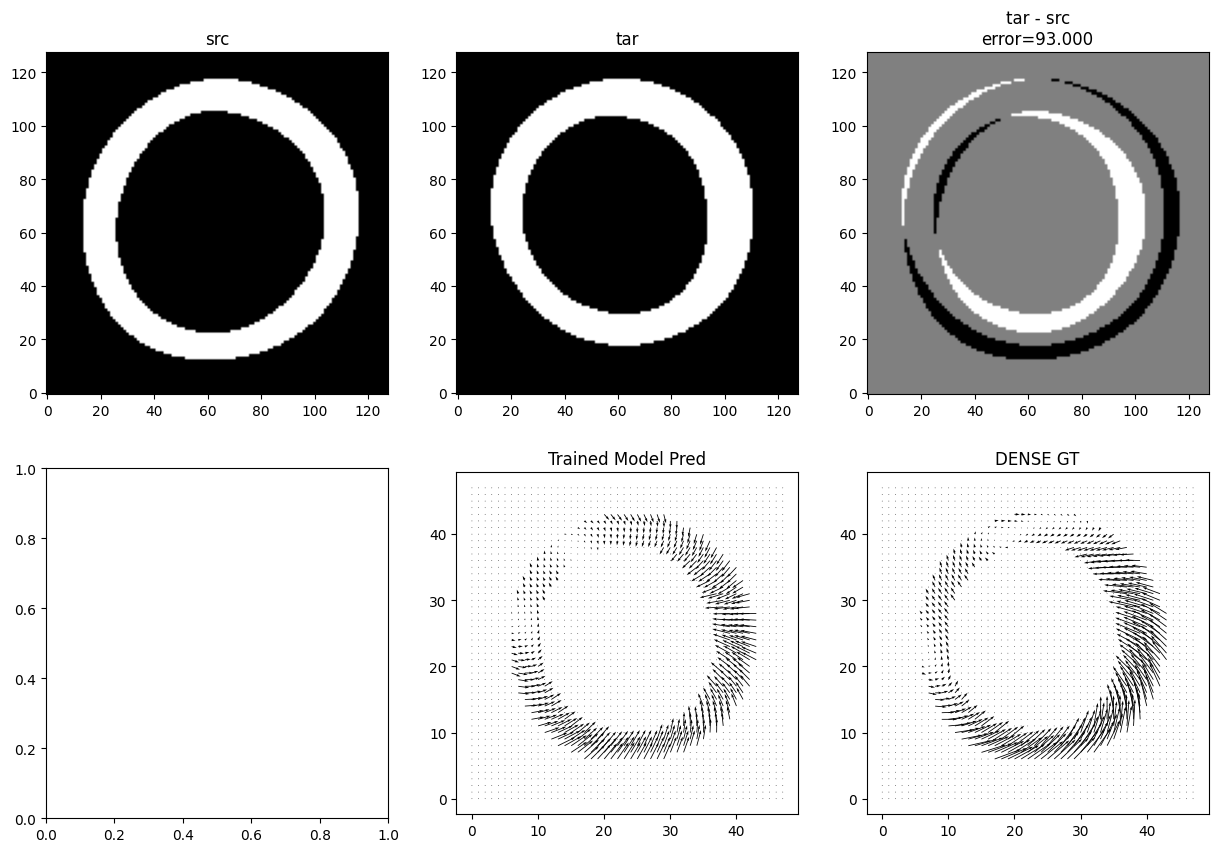

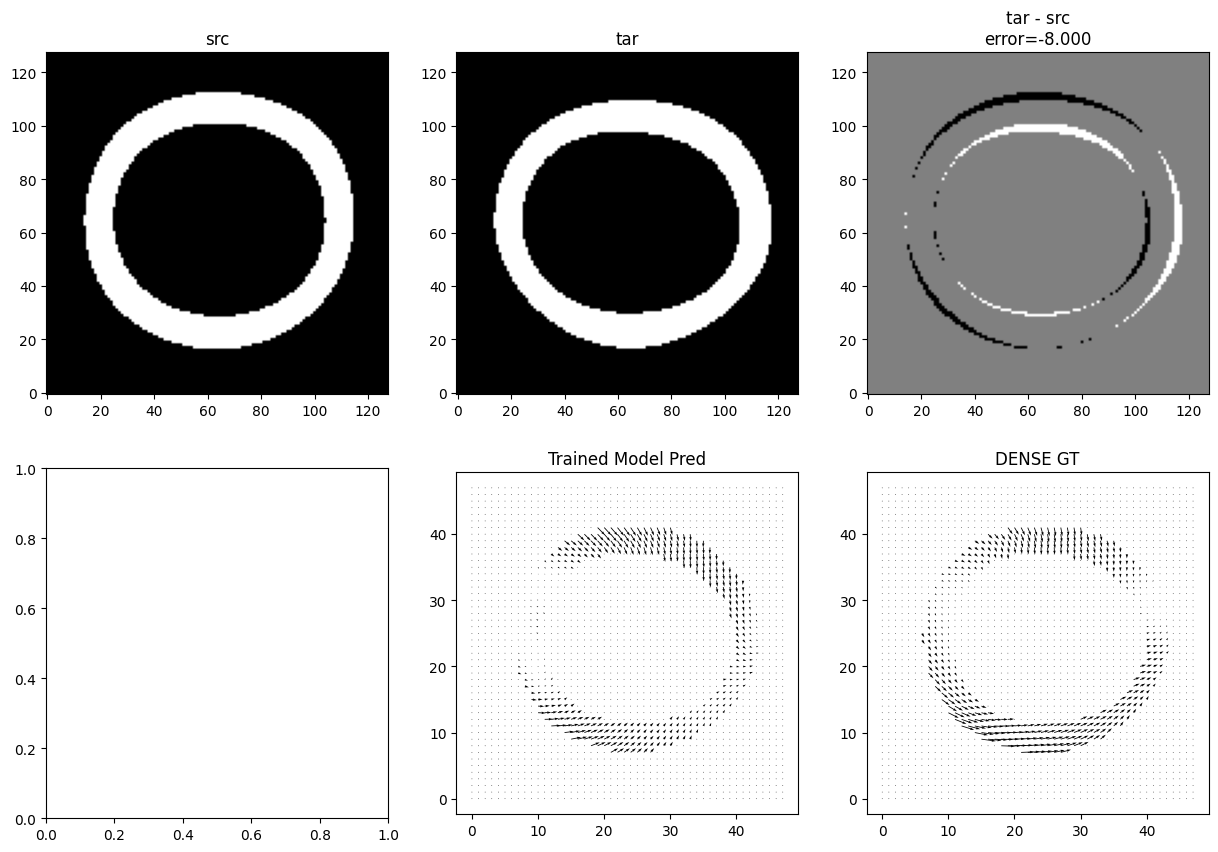

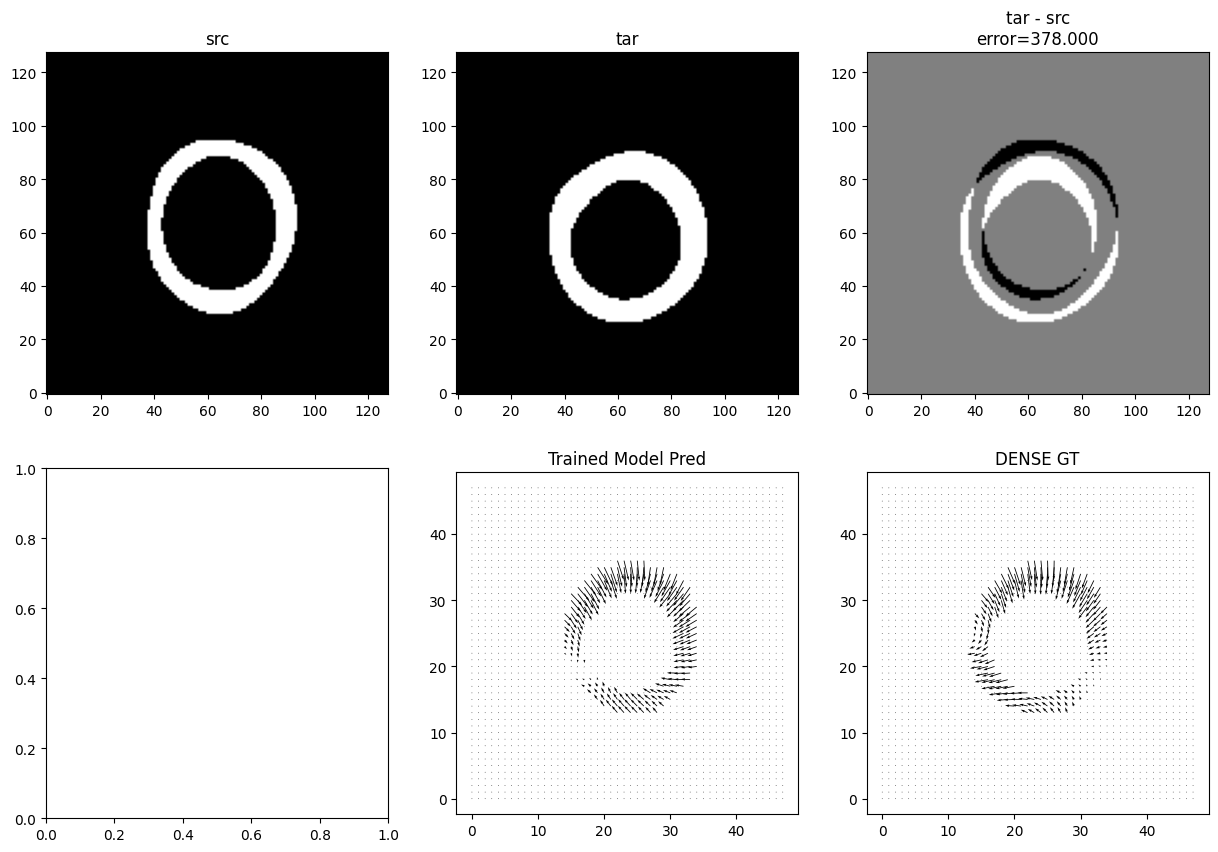

In [21]:
# compare the source, target, target-source difference, registration results, trained model prediction results
import numpy as np
import matplotlib.pyplot as plt
for check_pair_idx in [5,10,20]:
    n_frames = test_pred[check_pair_idx]['src'].shape[1]
    vis_frame = n_frames//2
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[vis_frame]
    tar_src_diff = tar - src
    
    # deformed = train_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    # deformed_bin = deformed > 0.5
    # deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    # disp_reg_pred  = test_pred[check_pair_idx]['reg_disp_pred'][:, vis_frame][:, ::2,::2]
    disp_pred = test_pred[check_pair_idx]['DENSE_disp_pred'][:, vis_frame]
    disp_GT = test_pred[check_pair_idx]['DENSE_disp'][:, vis_frame]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0,0].imshow(src, cmap='gray')
    axs[0,0].set_title('src')
    axs[0,0].invert_yaxis()
    axs[0,1].imshow(tar, cmap='gray')
    axs[0,1].set_title('tar')
    axs[0,1].invert_yaxis()
    axs[0,2].imshow(tar_src_diff, cmap='gray')
    axs[0,2].set_title(f'tar - src\nerror={tar_src_diff.sum():.3f}')
    axs[0,2].invert_yaxis()

    # axs[1,0].quiver(disp_reg_pred[0], disp_reg_pred[1], scale=1, units='xy')
    # # axs[7].invert_yaxis()
    # axs[1,0].set_title('Registration Pred')
    # axs[1,0].set_aspect('equal')
    
    axs[1,1].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    axs[1,1].set_title('Trained Model Pred')
    axs[1,1].set_aspect('equal')

    axs[1,2].quiver(disp_GT[0], disp_GT[1], scale=1, units='xy')
    axs[1,2].set_title('DENSE GT')
    axs[1,2].set_aspect('equal')
